In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
import unicodedata
import pandas as pd
import seaborn as sns
import numpy as np
import re
from itertools import islice

#### 1. Plot a histogram of terms in alice

In [2]:
nltk.download('gutenberg')
alice = 'carroll-alice.txt'
corpus_words = nltk.corpus.gutenberg.words(alice)

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\erick\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [3]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def string_normalize(text):
    lower = [i.lower() for i in text]
    no_accents = [unicodedata.normalize('NFD', i) for i in lower]
    no_marks = [re.sub(pattern = '[^a-z0-9]', string = i, repl = "") for i in no_accents]
    no_noise = []
    for w in no_marks:
        if (w not in set(stopwords.words('english'))) and (w not in ['']):
            no_noise.append(w)
    return(no_noise)

def string_lemmatize(text):
    lem = WordNetLemmatizer()
    lem_text = [lem.lemmatize(i) for i in text]
    return(lem_text)

def string_stemmatize(text):
    stem = PorterStemmer()
    stem_text = [stem.stem(i) for i in text]
    return(stem_text)
    
def preprocTokens(text, tokenize = True, normalize = True, lemmatize = True, stem = True, count = False):
    if tokenize == True:
        text = nltk.word_tokenize(text)
    if normalize == True:
        text = string_normalize(text)
    if lemmatize == True:
        text = string_lemmatize(text)
    if stem == True:
        text = string_stemmatize(text)
    if count == True:
        text = FreqDist(text)
    return(text)

In [23]:
# Histogram of terms
document = " ".join([str(s) for s in corpus_words])
tokens = preprocTokens(document, tokenize = True, normalize = False, lemmatize = False, stem = False, count = True)
dataset = pd.DataFrame.from_dict(tokens, orient = 'index', columns = ['frequency'])

In [5]:
dataset.sort_values(ascending=False, by = 'frequency')[1:10]

,frequency
",",2418
the,1527
.,988
and,802
to,725
a,615
I,543
it,527
she,509


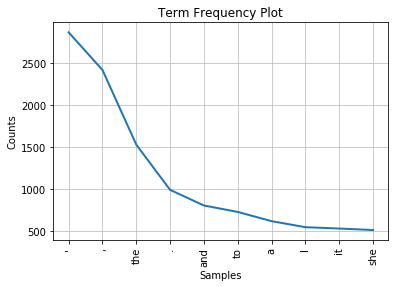

In [6]:
tokens.plot(10, cumulative=False,
                 title='Term Frequency Plot', linewidth=2)

In [7]:
# Histogram of normalized and lemmatized terms

# Histogram of terms
tokens2 = preprocTokens(document, tokenize = True, normalize = True, lemmatize = True, stem = False, count = True)
dataset2 = pd.DataFrame.from_dict(tokens2, orient = 'index', columns = ['frequency'])

In [8]:
dataset2.sort_values(ascending=False, by = 'frequency')[1:10]

,frequency
alice,398
little,128
one,105
know,90
like,86
went,83
would,83
thing,80
time,77


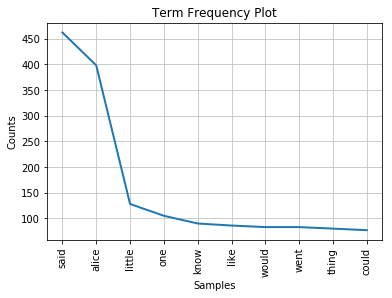

In [9]:
tokens2.plot(10, cumulative=False,
                 title='Term Frequency Plot', linewidth=2)

#### 2. Build a TD-M for the collection in books and find the most similar document content to the "Alice in Wonderland" usinf tf-idf and cosine similarity

In [10]:
books = ['shakespeare-macbeth.txt', 'chesterton-ball.txt','melville-moby_dick.txt','carroll-alice.txt']
alice = nltk.corpus.gutenberg.words(books[3])
alice = " ".join([str(s) for s in alice])
mbeth = nltk.corpus.gutenberg.words(books[0])
mbeth = " ".join([str(s) for s in mbeth])
chest = nltk.corpus.gutenberg.words(books[1])
chest = " ".join([str(s) for s in chest])
mob = nltk.corpus.gutenberg.words(books[2])
mob = " ".join([str(s) for s in mob])

documents = [alice, mbeth, chest, mob]

In [11]:
#  turn text into vectors of term frequency, overriding the tokenizer to perform lemmatization and stemmatization
from sklearn.feature_extraction.text import CountVectorizer
LemVectorizer = CountVectorizer(tokenizer=preprocTokens)
LemVectorizer.fit_transform(documents)

<4x13313 sparse matrix of type '<class 'numpy.int64'>'
	with 20949 stored elements in Compressed Sparse Row format>

In [12]:
d = LemVectorizer.vocabulary_ # tuple(terms, index)
take(5, d.items())

[('alic', 483),
 ('adventur', 366),
 ('wonderland', 13162),
 ('lewi', 6738),
 ('carrol', 1914)]

In [13]:
tf_matrix = LemVectorizer.transform(documents).toarray()
tf_matrix

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  1,  0],
       [ 0, 20,  0, ..., 10,  2,  1]], dtype=int64)

In [14]:
# This should be a 4 (# of documents) by 19104 (# of terms in the corpus). Check its shape:
tf_matrix.shape

(4, 13313)

In [22]:
# checking the frequency of a sample term
tf_matrix[:,483]

array([398,   0,   0,   0], dtype=int64)

In [16]:
# Now the TF-IDF matrix
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(norm="l2")
tfidf.fit(tf_matrix)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [17]:
# here is the idf for each term
tfidf.idf_

array([1.91629073, 1.51082562, 1.91629073, ..., 1.91629073, 1.51082562,
       1.91629073])

In [18]:
# and the tf-idf matrix
tfidf_matrix = tfidf.transform(tf_matrix)
tfidf_matrix

<4x13313 sparse matrix of type '<class 'numpy.float64'>'
	with 20949 stored elements in Compressed Sparse Row format>

In [19]:
# Here what the transform method does is multiplying the tf matrix (4 by 19104) 
# by the diagonal idf matrix (41 by 41 with idf for each term on the main diagonal), 
# and dividing the tf-idf by the Euclidean norm.
tfidf_matrix.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00092012, 0.00072543, 0.00092012, ..., 0.        , 0.00072543,
        0.        ],
       [0.        , 0.00630612, 0.        , ..., 0.00399926, 0.00063061,
        0.00039993]])

In [20]:
# The cosine similarity matrix can be given by:
cos_similarity_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()
cos_similarity_matrix

array([[1.        , 0.14271568, 0.37817979, 0.27572294],
       [0.14271568, 1.        , 0.19456975, 0.23962084],
       [0.37817979, 0.19456975, 1.        , 0.41099575],
       [0.27572294, 0.23962084, 0.41099575, 1.        ]])

In [21]:
# Summarized way, skipping all the steps (exactly the same results):
from sklearn.feature_extraction.text import TfidfVectorizer
TfidfVec = TfidfVectorizer(tokenizer=preprocTokens)

def cos_similarity(documents_list):
    tfidf = TfidfVec.fit_transform(documents_list)
    return (tfidf * tfidf.T).toarray()

cos_similarity(documents)

array([[1.        , 0.14271568, 0.37817979, 0.27572294],
       [0.14271568, 1.        , 0.19456975, 0.23962084],
       [0.37817979, 0.19456975, 1.        , 0.41099575],
       [0.27572294, 0.23962084, 0.41099575, 1.        ]])

R: Chesterton's book is the most similar to Alice's Wonderland (cosine similarity of .378)